In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import warnings

import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import teotil3 as teo
from geopy.distance import geodesic
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# TEOTIL3 Trondheimsfjorden

# Part 3: Observed fluxes

## 1. Filter observed chemistry data based on monitoring frequency

In [4]:
# Parameters to compare
par_cols = ["TOTN_ug/l", "TOTP_ug/l"]

# Sampling frequency criteria
min_qtrs_per_year = 4  # At least one sample per year quarter per site
min_yrs_per_site = 3  # At least three years of data per site

In [5]:
# Read chem and flow
chem_col_dict = {
    "sampling_date": "date",
    "DIN_µgplN": "DIN_ug/l",
    "TDP_µgplP": "TDP_ug/l",
    "TOC_mgplC": "TOC_mg/l",
    "TON_µgplN": "TON_ug/l",
    "TOTN_µgplN": "TOTN_ug/l",
    "TOTP_µgplN": "TOTP_ug/l",
    "TPP_µgplP": "TPP_ug/l",
}
wc_df = pd.read_excel(r"../data/vm_raw_water_chem.xlsx")
wc_df["sampling_date"] = wc_df["sampling_date"].dt.normalize()
wc_df.rename(columns=chem_col_dict, inplace=True)
cols = ["station_code"] + list(chem_col_dict.values())
wc_df = wc_df[cols]

q_df = pd.read_excel(
    r"../data/nve_hydapi_raw_discharge_trondheimsfjorden_2013-2023.xlsx"
)
q_df["datetime"] = q_df["datetime"].dt.normalize()
q_df.rename(columns={"datetime": "date", "value": "flow_m3/s"}, inplace=True)

# Read station data
vm_stn_df = pd.read_excel(r"../data/vm_chem_stations.xlsx")
vm_stn_df.drop(
    columns=[
        "utm33_east",
        "utm33_north",
        "vannreg_id",
        "vannreg_name",
        "fylke",
        "kommune",
        "vassom_id",
        "vassom_name",
        "vannom_id",
        "vannom_name",
    ],
    inplace=True,
)
vm_stn_df.head()

nve_stn_df = pd.read_excel(r"../data/nve_hydapi_stations.xlsx")
nve_stn_df.rename(
    columns={
        "latitude": "lat",
        "longitude": "lon",
        "drainageBasinArea": "nve_upstream_area_km2",
        "regineNo": "regine",
    },
    inplace=True,
)
nve_stn_df.drop(columns=["specificDischarge"], inplace=True)

In [6]:
# Require complete data for main pars of interest (but keep other pars too)
wc_df = wc_df.dropna(subset=par_cols, how="any")

# Filter based on sampling freq
wc_df["year"] = wc_df["date"].dt.year
wc_df["quarter"] = wc_df["date"].dt.quarter

# Count number of quarters sampled each year at each station.
stn_uniq_qtrs = wc_df.groupby(["station_code", "year"])["quarter"].nunique()
stn_uniq_qtrs = stn_uniq_qtrs[stn_uniq_qtrs == min_qtrs_per_year].reset_index()

# For stations with enough data per quarter, count total years with data
stn_yrs = stn_uniq_qtrs.groupby("station_code")["year"].count()
stn_yrs = stn_yrs[stn_yrs >= min_yrs_per_site].reset_index()

# Filter
valid_stns = list(stn_yrs["station_code"].unique())
vm_stn_df = vm_stn_df.query("station_code in @valid_stns").reset_index(drop=True)

print(f"The following {len(vm_stn_df)} stations meet the specificed criteria:")
vm_stn_df

The following 4 stations meet the specificed criteria:


,station_code,station_name,lon,lat,type,waterbody_id,waterbody_name
0,121-38517,Orkla ved Vormstad,9.771943,63.200589,R,121-55-R,"Orkla, samløp Raubekken - Vormstad"
1,123-38525,Nidelva (Trøndelag) ved Bakke bru,10.405893,63.432799,R,123-29-R,Nidelva nedenfor Nedre Leirfoss
2,127-38540,Verdalselva,11.474460,63.791654,R,127-36-R,Verdalselva nedre
3,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,11.155649,63.689450,R,126-86-R,Hotranvassdraget


## 2. Link water chemistry stations to discharge stations

Since there aren't many stations meeting the criteria, I have manually assigned appropriate regine IDs and NVE stations using Vannmiljø and NVE Atlas. Note that one site should be based on summed flows from two NVE sites.

In [7]:
# Link chem stations to NVE stations and model regines
# vm_code => (reg_id, [nve_id_list])
stn_map = {
    "127-38540": ("127.A0", ["127.13.0", "127.6.0"]),
    "123-38525": ("123.A11", ["123.20.0"]),
    "126-54258": ("126.4Z", ["126.2.0"]),
    "121-38517": ("121.A41", ["121.22.0"]),
}
nve_stns = [
    nve_code
    for vm_code, (reg_id, nve_codes) in stn_map.items()
    for nve_code in nve_codes
]
nve_stn_df = nve_stn_df.query("station_id in @nve_stns").reset_index(drop=True)
nve_stn_df

,station_id,station_name,lat,lon,nve_upstream_area_km2,regine
0,121.22.0,Syrstad,63.03225,9.72771,2278.34,121.B421
1,123.20.0,Rate,63.38490,10.39023,3057.88,123.A2
2,126.2.0,Engstad,63.68956,11.15570,20.13,126.4Z
3,127.13.0,Dillfoss,63.76420,11.76507,479.64,127.AA0
4,127.6.0,Grunnfoss,63.79150,11.81244,880.42,127.B1


## 3. Calculate catchment areas

In [8]:
# Chem sites
vm_stn_gdf = nivapy.spatial.derive_watershed_boundaries(
    vm_stn_df,
    id_col="station_code",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=5,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
vm_stn_gdf["upstream_area_km2"] = (
    vm_stn_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
)
vm_stn_df = pd.merge(
    vm_stn_df,
    vm_stn_gdf[["station_code", "upstream_area_km2"]],
    how="left",
    on="station_code",
)

# Flow sites
nve_stn_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=5,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
nve_stn_gdf["upstream_area_km2"] = (
    nve_stn_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
)
nve_stn_df = pd.merge(
    nve_stn_df,
    nve_stn_gdf[["station_id", "upstream_area_km2"]],
    how="left",
    on="station_id",
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 121:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 123:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 126:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 127:   0%|          | 0/1 [00:00<?, ?it/s]

Connection successful.


Looping over vassdragsområder:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 121:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 123:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 126:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 127:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Check nivapy areas ~ NVE areas where available
scatter_plot = (
    alt.Chart(nve_stn_df)
    .mark_circle(color="red")
    .encode(
        x=alt.X("nve_upstream_area_km2", title="NVE area (km2)"),
        y=alt.Y("upstream_area_km2", title="Calculated area (km2)"),
        tooltip=["station_id", "nve_upstream_area_km2", "upstream_area_km2"],
    )
    .properties(title="NVE area vs Calculated area")
)
line = (
    alt.Chart(nve_stn_df)
    .mark_line(color="black")
    .encode(x="nve_upstream_area_km2", y="nve_upstream_area_km2")
)
plot = scatter_plot + line
plot

alt.LayerChart(...)

## 4. Estimate fluxes

In [10]:
df_list = []
for vm_code, (reg_id, nve_codes) in stn_map.items():
    vm_area = vm_stn_df.query("station_code == @vm_code")["upstream_area_km2"].iloc[0]
    nve_area = nve_stn_df.query("station_id in @nve_codes")["upstream_area_km2"].sum()
    area_fac = vm_area / nve_area
    print("####", vm_code)
    print(f"Chemistry station area (km2): {vm_area:.2f}")
    print(f"Discharge station area (km2): {nve_area:.2f}")
    print(f"Area factor: {area_fac:.2f}\n")
    stn_wc_df = (
        wc_df.query("station_code == @vm_code")
        .drop(columns=["station_code", "year", "quarter"])
        .set_index("date")
    )
    stn_q_df = area_fac * q_df.query("station_id in @nve_codes").groupby("date").sum(
        numeric_only=True
    )
    flux_df = nivapy.stats.estimate_fluxes(
        stn_q_df,
        stn_wc_df,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
        st_date=None,
        end_date=None,
        plot_fold=None,
    ).dropna(how="all")
    par_cols = list(flux_df.columns)
    flux_df = flux_df.reset_index()
    flux_df["station_code"] = vm_code
    flux_df = flux_df[["station_code", "year"] + par_cols]

    # Add annual mean flows
    stn_q_df = stn_q_df.resample("YE").mean()
    stn_q_df["year"] = stn_q_df.index.year
    stn_q_df.reset_index(drop=True)
    flux_df = pd.merge(flux_df, stn_q_df, how="left", on="year")
    df_list.append(flux_df)
flux_df = pd.concat(df_list, axis="rows")
flux_df.columns = [col.lower() for col in flux_df.columns]
for col in flux_df.columns:
    if col not in ["station_code", "year"]:
        flux_df.rename(columns={col: "obs_" + col}, inplace=True)

flux_df.head()

#### 127-38540
Chemistry station area (km2): 1464.71
Discharge station area (km2): 1360.78
Area factor: 1.08

#### 123-38525
Chemistry station area (km2): 3112.09
Discharge station area (km2): 3052.22
Area factor: 1.02

#### 126-54258
Chemistry station area (km2): 19.88
Discharge station area (km2): 19.88
Area factor: 1.00

#### 121-38517
Chemistry station area (km2): 2834.54
Discharge station area (km2): 2275.66
Area factor: 1.25



,station_code,year,obs_din_kg,obs_tdp_kg,obs_toc_kg,obs_ton_kg,obs_totn_kg,obs_totp_kg,obs_tpp_kg,obs_flow_m3/s
0,127-38540,2015,275132.558013,NaN,8.005815e+06,356371.147095,631503.705107,13588.108282,NaN,76.941451
1,127-38540,2018,126136.299282,3118.199709,5.670068e+06,164867.298732,291003.598015,10772.224126,3552.020699,49.438732
2,127-38540,2021,282423.377622,NaN,7.851161e+06,243887.435593,526310.813215,8570.465839,NaN,66.288902
0,123-38525,2013,260928.846873,NaN,7.012754e+06,320262.724360,581191.571233,10052.024913,NaN,90.459958
1,123-38525,2014,215774.137855,NaN,4.524518e+06,194331.169566,410105.307421,7858.472236,NaN,60.485367


In [11]:
# Filter out bad data for Hotranelva
# NVE's flow data for Engstad/Hotranelva in 2014 is clearly wrong -
# see email sent to Sigrun 01.11.2024. Furthermore, NIBIO do not report
# fluxes for Hotranelva in 2013 or 2014, apparently due to missing data.
# To see this, download the flux data here:
# https://jovadata.nibio.no/download/catchment/hot/mass-transfer
# I will therefore remove observed data for Hotranelva in 2013 and 2014
# from the comparison
flux_df = flux_df[
    ~((flux_df["station_code"] == "126-54258") & (flux_df["year"].isin([2013, 2014])))
]

## 4. Compare to model results

In [12]:
# Model settings
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
agri_loss_model = "annual"  # 'annual' or 'risk'
model_output_csv_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [13]:
# Read model results
mod_csv = os.path.join(
    model_output_csv_fold,
    f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}_agri-{agri_loss_model}-loss.csv",
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,125.911370,0.752367,3.420677,6341.957245,69.787520,195.698890,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712744,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


In [14]:
pars = ["totn", "ton", "din", "totp", "tdp", "tpp", "toc"]
mod_tot_df = mod_df.copy()
mod_tot_df.rename(columns={"accum_q_m3/s": "mod_flow_m3/s"}, inplace=True)
for par in pars:
    par_cols = [
        col
        for col in mod_tot_df.columns
        if col.startswith("accum_") and col.endswith(f"_{par}_kg")
    ]
    mod_tot_df[f"mod_{par}_kg"] = mod_tot_df[par_cols].sum(axis="columns")
    mod_tot_df.drop(par_cols, axis="columns", inplace=True)
cols = ["regine", "year"] + [col for col in mod_tot_df if col.startswith("mod_")]
mod_tot_df = mod_tot_df[cols]
mod_tot_df.head()

,regine,year,mod_flow_m3/s,mod_totn_kg,mod_ton_kg,mod_din_kg,mod_totp_kg,mod_tdp_kg,mod_tpp_kg,mod_toc_kg
0,001.10,2013,0.019586,222.300000,186.200000,36.100000,5.400000,0.600000,4.800000,9938.900000
1,001.1A2B,2013,0.749662,6222.096391,3848.769092,2373.327300,68.941389,63.826265,5.115124,141265.056356
2,001.1A4D,2013,0.129308,1481.594012,1045.184379,436.409633,10.120989,6.158887,3.962102,44971.940123
3,001.1M,2013,0.272519,2145.653814,1599.515932,546.137882,9.571569,7.201386,2.370183,65626.616015
4,001.21,2013,0.001987,30.900000,25.900000,5.000000,0.800000,0.100000,0.700000,1386.100000


In [15]:
# Link model upstream areas to chem stations
vm_stn_df["regine"] = [
    stn_map[vm_code][0] for vm_code in vm_stn_df["station_code"].tolist()
]
area_up_df = mod_df[["regine", "accum_upstr_area_km2"]].drop_duplicates()
vm_stn_df = pd.merge(vm_stn_df, area_up_df, how="left", on="regine")

In [16]:
# Compare modelled totals
df_list = []
for idx, row in vm_stn_df.iterrows():
    vm_code = row["station_code"]
    reg_id = row["regine"]
    scale_fac = row["upstream_area_km2"] / row["accum_upstr_area_km2"]
    stn_obs_df = (
        flux_df.query("station_code == @vm_code")
        .drop(columns="station_code")
        .set_index("year")
    )
    stn_mod_df = scale_fac * mod_tot_df.query("regine == @reg_id").drop(
        columns="regine"
    ).set_index("year")
    comp_df = pd.concat([stn_mod_df, stn_obs_df], axis="columns")
    comp_df = comp_df.reset_index("year").melt(id_vars="year").dropna(subset="value")
    comp_df["station_code"] = vm_code
    comp_df[["type", "par_unit"]] = comp_df["variable"].str.split("_", n=1, expand=True)
    del comp_df["variable"]
    df_list.append(comp_df)
comp_df = pd.concat(df_list, axis="rows")

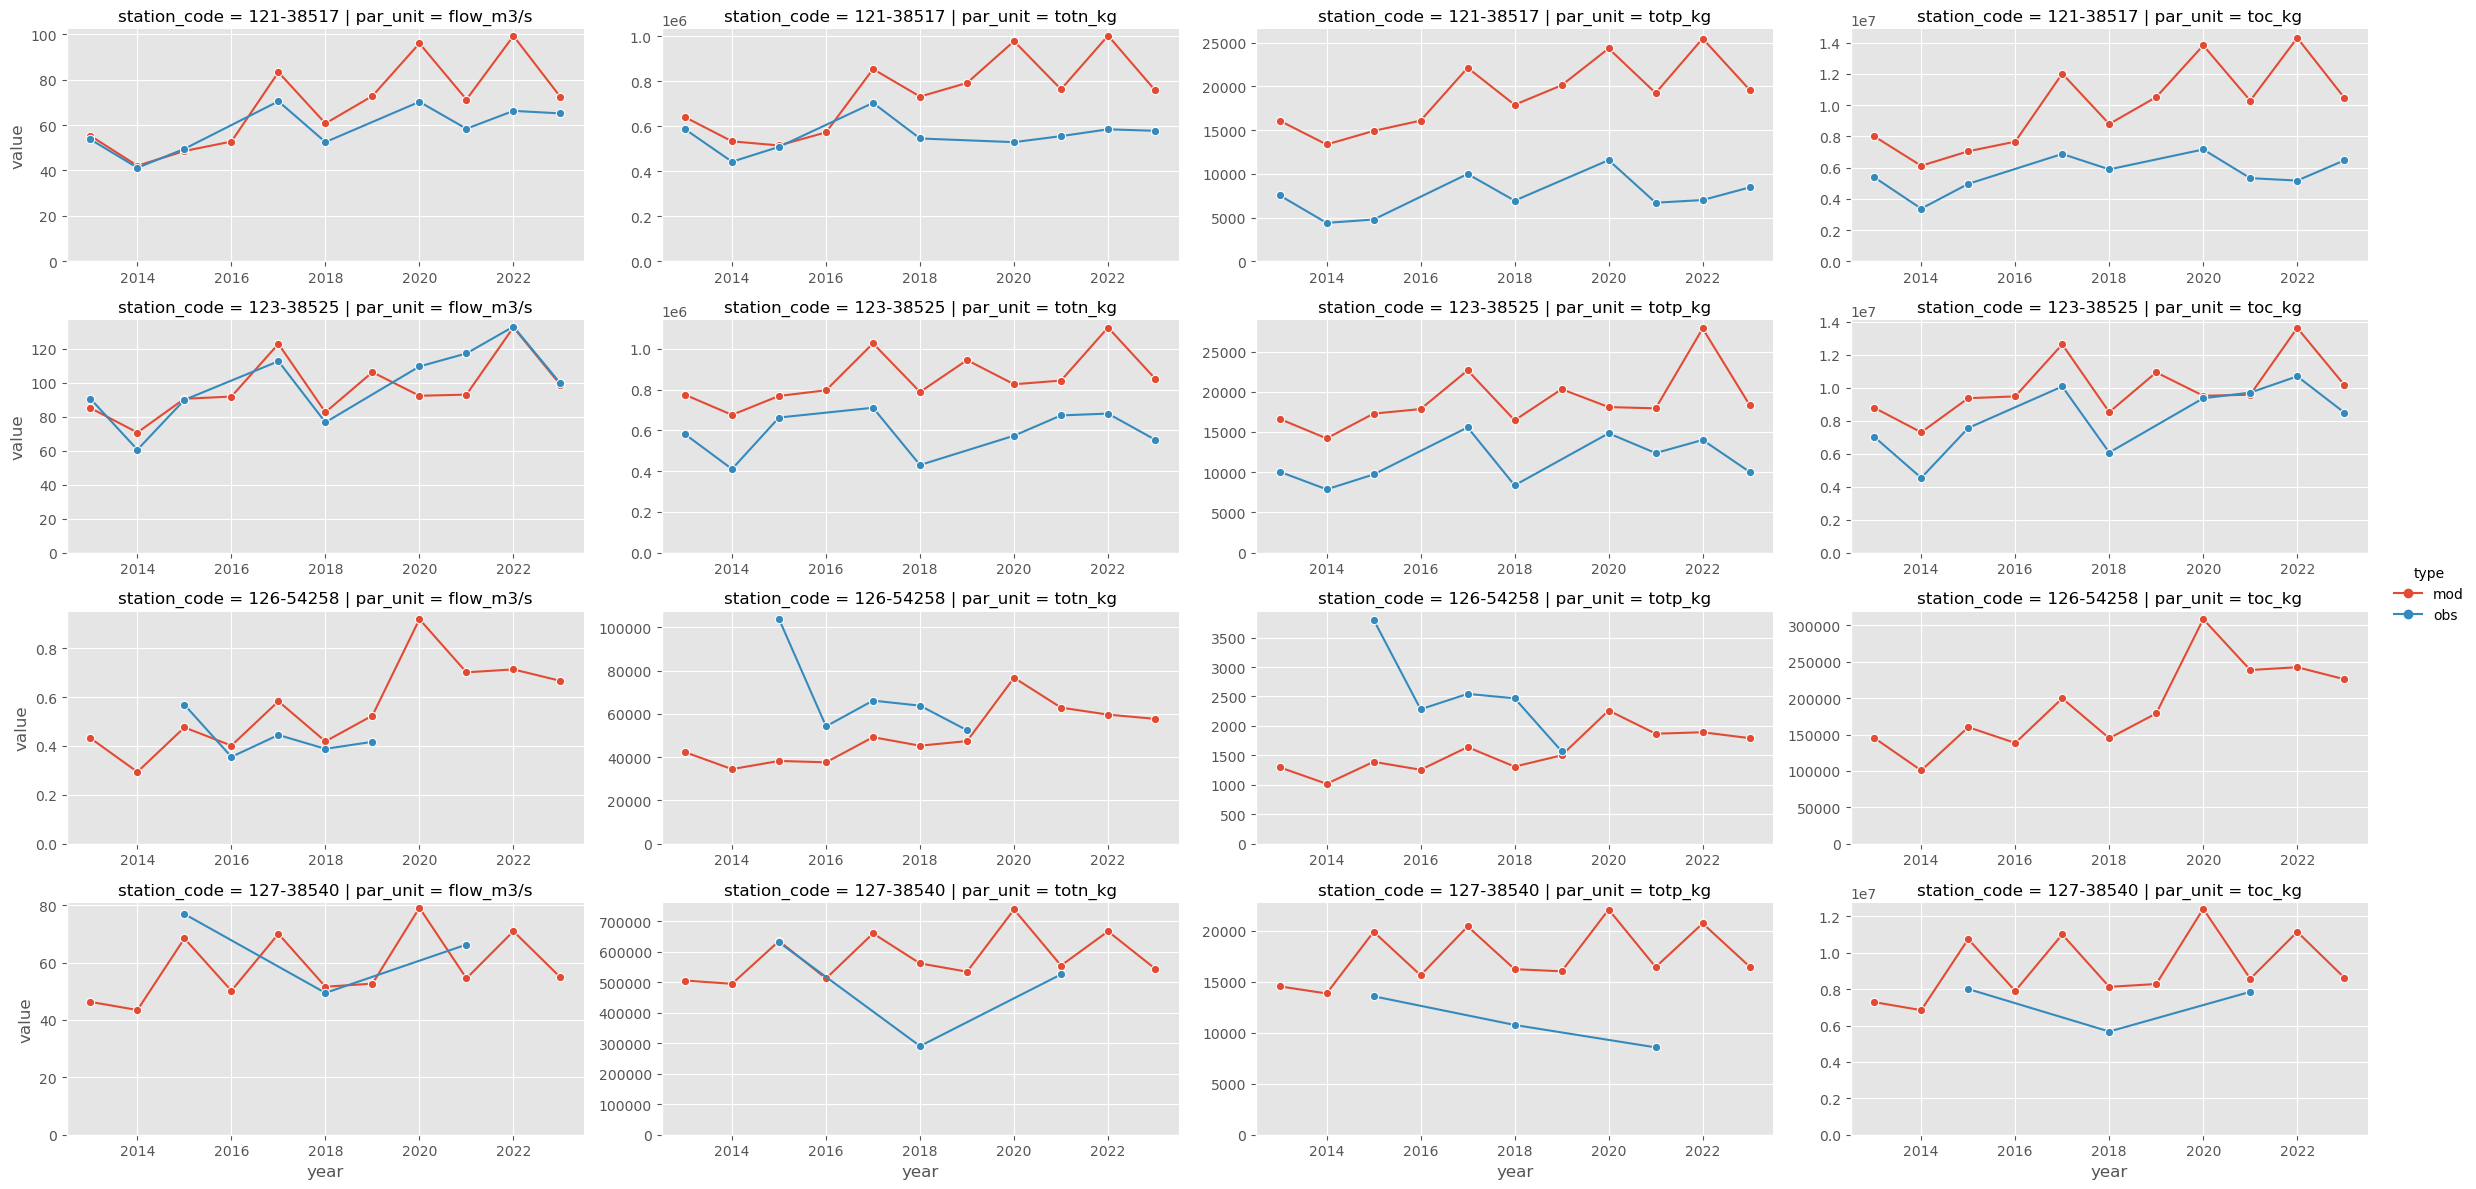

In [17]:
comp_pars = ["totn_kg", "totp_kg", "toc_kg", "flow_m3/s"]
comp_df2 = (
    comp_df.query("par_unit in @comp_pars").sort_values(["station_code", "year"]).copy()
)
g = sn.relplot(
    data=comp_df2,
    x="year",
    y="value",
    row="station_code",
    col="par_unit",
    hue="type",
    kind="line",
    marker="o",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": False},
)
for ax in g.axes.flatten():
    ax.set_ylim(0, None)

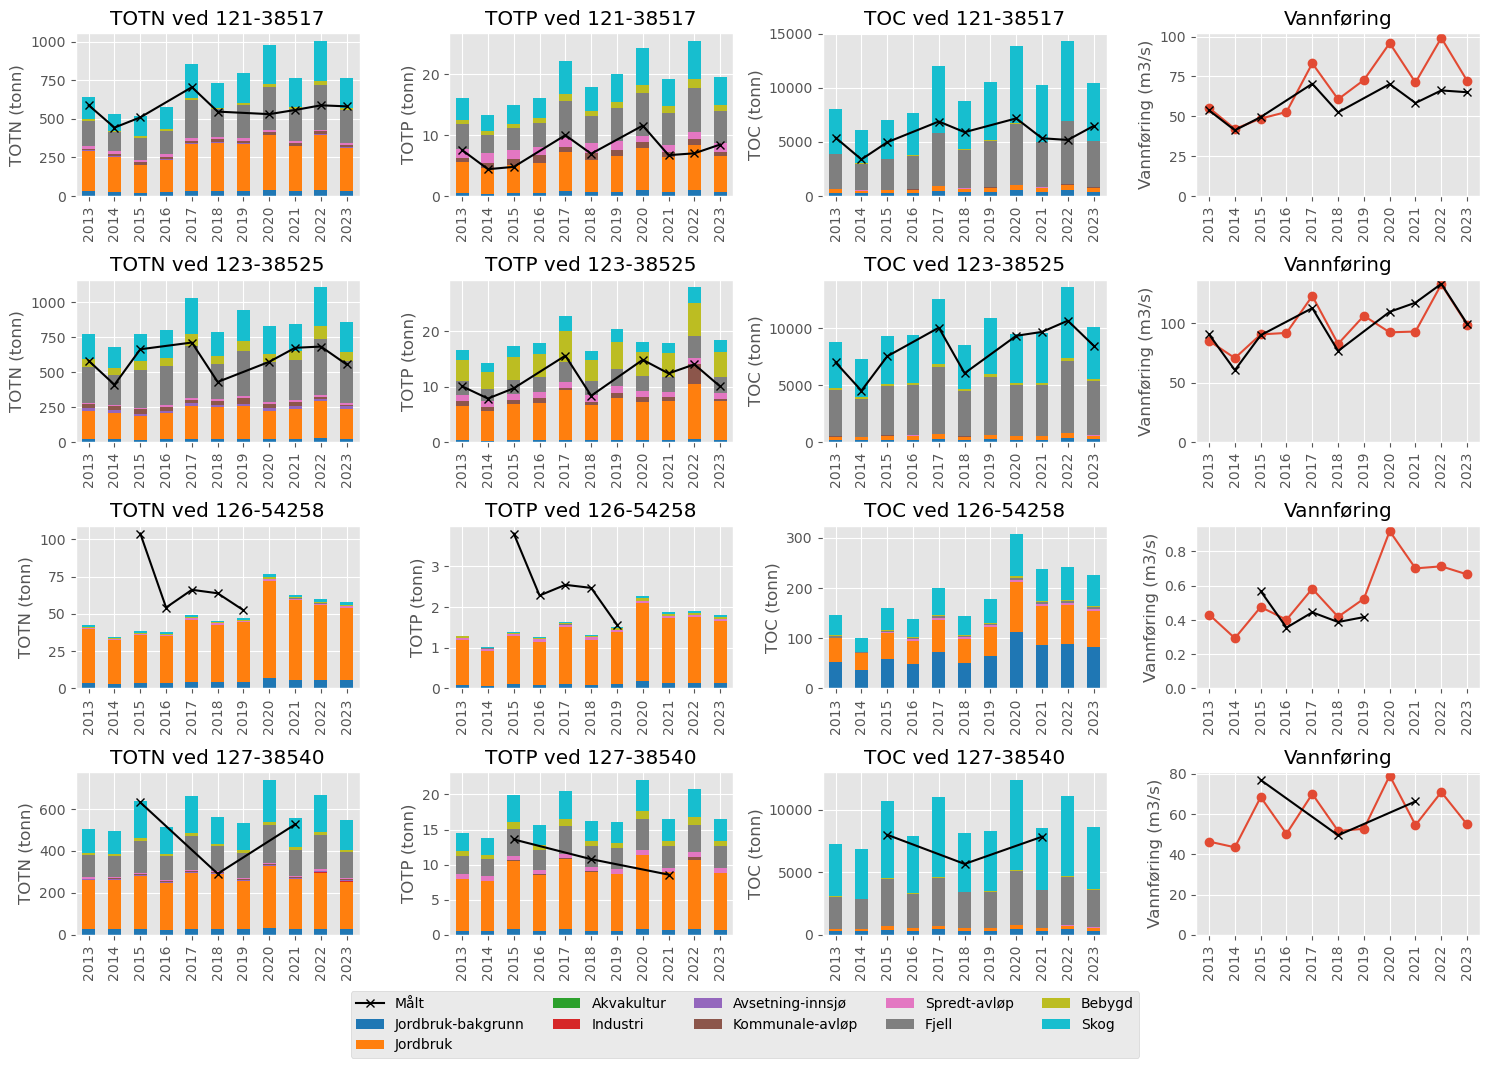

In [18]:
# Plots showing stacked bar charts of source contributions overlaid with obs data
def _remove_prefix(text, prefix):
    """Remove 'prefix' from 'text'."""
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


names_dict = {
    "Agriculture-background": "Jordbruk-bakgrunn",
    "Agriculture": "Jordbruk",
    "Aquaculture": "Akvakultur",
    "Industry": "Industri",
    "Large-wastewater": "Kommunale-avløp",
    "Spredt": "Spredt-avløp",
    "Upland": "Fjell",
    "Urban": "Bebygd",
    "Wood": "Skog",
    "Lake": "Avsetning-innsjø"
}

# Setup plot
fig, axes = plt.subplots(nrows=len(vm_stn_df), ncols=4, figsize=(15, 10))

for row_idx, row in vm_stn_df.sort_values("station_code").reset_index().iterrows():
    vm_code = row["station_code"]
    reg_id = row["regine"]
    scale_fac = row["upstream_area_km2"] / row["accum_upstr_area_km2"]

    # Get model results
    reg_df = mod_df.query("regine == @reg_id").copy().set_index("year")
    cols = [col for col in reg_df.columns if col.startswith("accum")]
    reg_df = reg_df[cols].copy()
    cols = [_remove_prefix(col, "accum_") for col in cols]
    reg_df.columns = cols

    # Scale to match observed area
    reg_df = reg_df * scale_fac

    # Get observed data
    obs_df = flux_df.query("station_code == @vm_code").copy().set_index("year")
    cols = [col for col in obs_df.columns if col.startswith("obs")]
    obs_df = obs_df[cols].copy()
    cols = [_remove_prefix(col, "obs_") for col in cols]
    obs_df.columns = cols

    # Loop over pars
    pars = ["TOTN", "TOTP", "TOC"]
    for col_idx, par in enumerate(pars):
        # Stacked bar charts for each chem parameter
        par_cols = [
            col
            for col in reg_df.columns
            if (par.lower() in (i.lower() for i in col.split("_")))
            and not col.startswith("trans_")
        ]
        units = [col.split("_")[-1] for col in par_cols]
        if len(set(units)) != 1:
            raise ValueError(
                f"Results for {par} use inconsistent units ({set(units)})."
            )
        unit = units[0]
        par_df = reg_df[par_cols].copy()
        par_cols = [col.split("_")[0].capitalize() for col in par_cols]
        par_df.columns = par_cols

        # Convert to Norwegian labels
        par_df.rename(columns=names_dict, inplace=True)
        
        if unit == "kg":
            par_df = par_df / 1000
        par_df.plot(
            kind="bar",
            stacked=True,
            ax=axes[row_idx, col_idx],
            legend=False,
            cmap="tab10",
        )
        axes[row_idx, col_idx].set_title(f"{par} ved {vm_code}")
        axes[row_idx, col_idx].set_ylabel(f"{par} (tonn)")
        axes[row_idx, col_idx].set_xlabel("")

        # Observed fluxes
        obs_par_df = obs_df[[f"{par.lower()}_kg"]].copy()
        obs_par_df[f"{par}_tonnes"] = obs_df[f"{par.lower()}_kg"] / 1000
        axes[row_idx, col_idx].plot(
            obs_par_df.index - 2013,
            obs_par_df[f"{par}_tonnes"],
            marker="x",
            color="k",
            label="Målt",
        )

    # Line plot for modelled discharge
    q_df = reg_df[["q_m3/s"]].copy()
    q_df.plot(ax=axes[row_idx, -1], legend=False, marker="o")

    # Line plot for observed discharge
    axes[row_idx, -1].plot(
        obs_df.index,
        obs_df["flow_m3/s"],
        marker="x",
        color="k",
        label="Målt",
    )

    axes[row_idx, -1].set_title("Vannføring")
    axes[row_idx, -1].set_ylabel("Vannføring (m3/s)")
    axes[row_idx, -1].set_xlabel("")
    axes[row_idx, -1].set_ylim(0, None)

    # Set x-ticks and labels to match other subplots
    axes[row_idx, -1].set_xticks(q_df.index)
    axes[row_idx, -1].set_xticklabels(q_df.index, rotation=90)

plt.tight_layout()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.07), ncol=5)
plt.savefig(r"../results/images/mod_vs_obs_fluxes.png", dpi=200, bbox_inches="tight")